In [1]:
# Import required libraries
import pandas as pd 
import numpy as np 
import string
import re
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Load movies data
df = pd.read_csv('movies_data.csv')

In [3]:
# Show initial information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

In [4]:
df.drop(['imdb_id', 'homepage', 'tagline', 'keywords','budget_adj','production_companies', 'revenue_adj'], axis = 1, inplace=True)

In [5]:
# Finding Missing values in all columns
miss = pd.DataFrame(df.isnull().sum())
miss = miss.rename(columns={0: "miss_count"})
miss["miss_%"] = (miss.miss_count / len(df.id)) * 100
miss

,miss_count,miss_%
id,0,0.000000
popularity,0,0.000000
budget,0,0.000000
revenue,0,0.000000
original_title,0,0.000000
cast,76,0.699429
director,44,0.404933
overview,4,0.036812
runtime,0,0.000000
genres,23,0.211669


In [6]:
# Dropping Na's from the following columns
df.dropna(subset=['director','genres', 'cast', 'overview'],inplace=True)
df.reset_index(inplace=True,drop=True)

# Duplicate data delete
print(df.duplicated().sum())
df.drop_duplicates(inplace= True)
print(df.duplicated().sum())


1
0


In [7]:
df.isna().sum()

id                0
popularity        0
budget            0
revenue           0
original_title    0
cast              0
director          0
overview          0
runtime           0
genres            0
release_date      0
vote_count        0
vote_average      0
release_year      0
dtype: int64

In [8]:
df.head(3)

,id,popularity,budget,revenue,original_title,cast,director,overview,runtime,genres,release_date,vote_count,vote_average,release_year
0,135397,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,6/9/2015,5562,6.5,2015
1,76341,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,5/13/2015,6185,7.1,2015
2,262500,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,3/18/2015,2480,6.3,2015


In [9]:
df['overview'][0]

'Twenty-two years after the events of Jurassic Park, Isla Nublar now features a fully functioning dinosaur theme park, Jurassic World, as originally envisioned by John Hammond.'

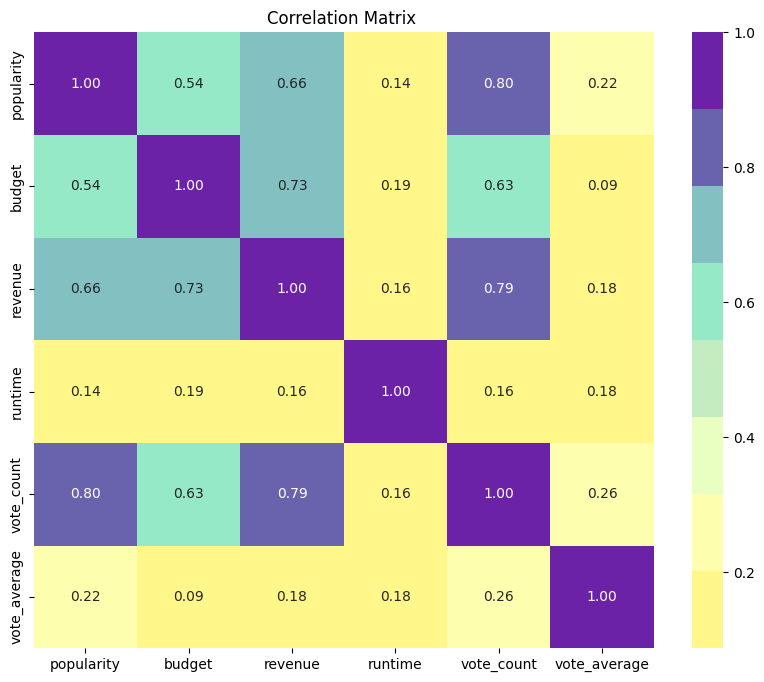

In [10]:
numeric_columns = ['popularity', 'budget', 'revenue', 'runtime', 'vote_count', 'vote_average']

correlation_matrix = df[numeric_columns].corr()

# Visualizing the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=['#FFF78A', '#FDFFAE', '#E9FFC2', '#C3EDC0', '#96E9C6', '#83C0C1', '#6962AD', '#6C22A6'], fmt=".2f")
plt.title("Correlation Matrix ")
plt.show()


# Visualization

<Figure size 2000x500 with 0 Axes>

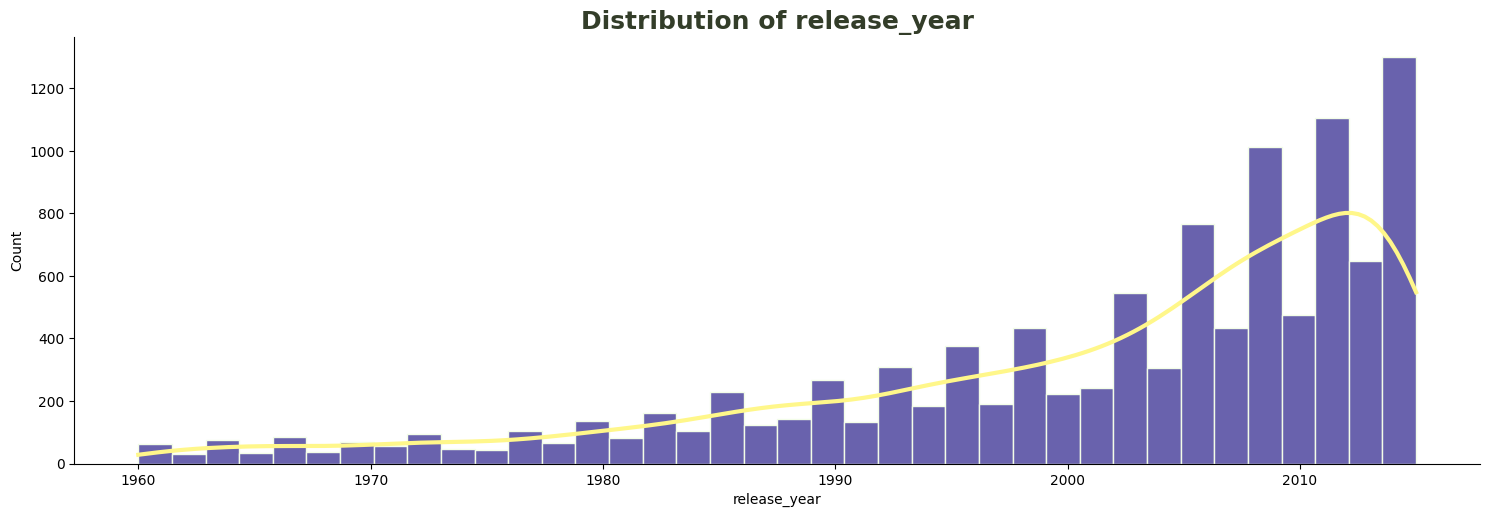

<Figure size 2000x500 with 0 Axes>

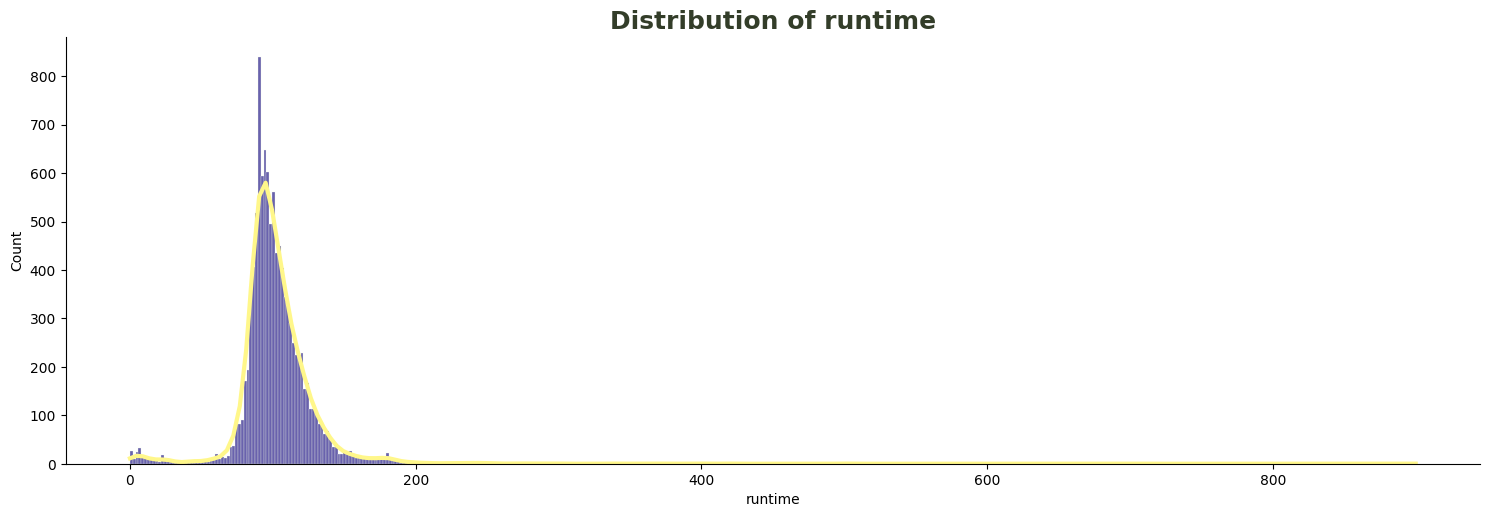

In [11]:
# release_year and runtime column distribution
def plot_distribution(data, column, figsize=(20, 5), kde=True):
    plt.figure(figsize=figsize) 
    sns.displot(data=data, x=column, kde=kde, color='#FFF78A' , facecolor= '#6962AD', edgecolor='#F3FDE8', line_kws={'lw': 3}, aspect=3)
    plt.title(f'Distribution of {column}', fontsize=18, weight=600, color='#333d29')
    plt.show()

plot_distribution(df, 'release_year')
plot_distribution(df, 'runtime')

In [12]:
genre_list = []
for genres_cell in df['genres']:
    genres = genres_cell.split('|')
    genre_list.extend(genres)

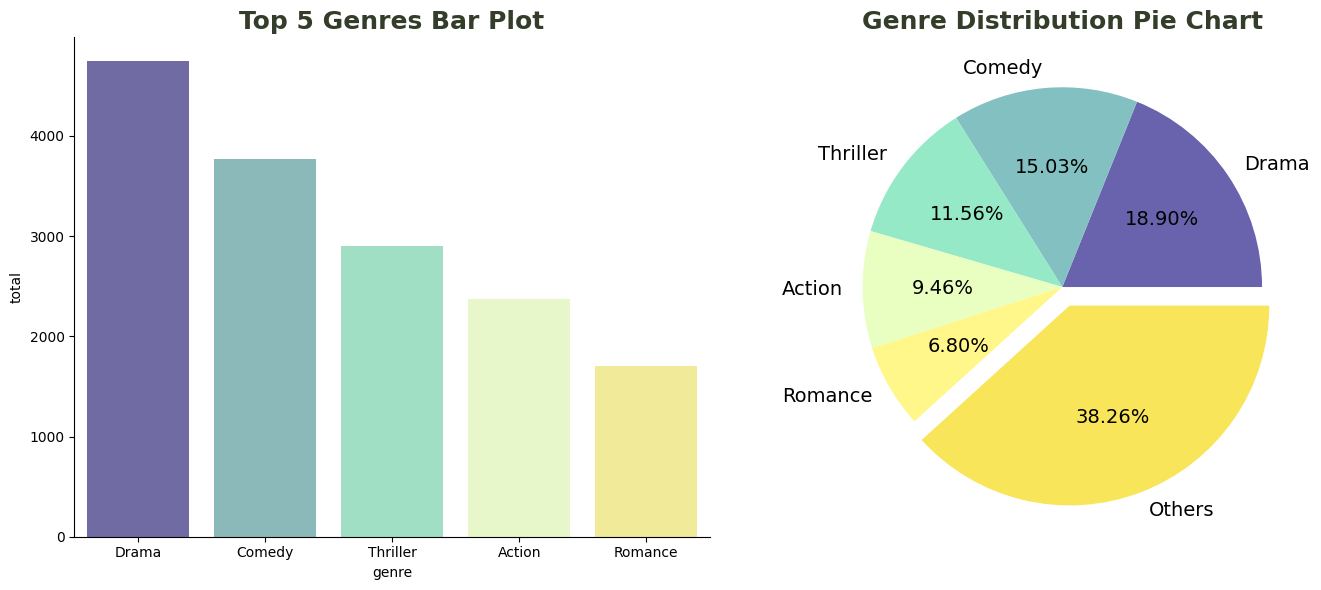

In [14]:
def genre_distribution(genre_list, figsize=(14, 6)):
    
    # Bar Plot
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    df_plot = pd.DataFrame(Counter(genre_list).most_common(5), columns=['genre', 'total'])
    ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#6962AD', '#83C0C1', '#96E9C6', '#E9FFC2', '#FFF78A'])
    ax.set_title('Top 5 Genres Bar Plot', fontsize=18, weight=600, color='#333d29')
    sns.despine()

    # Pie Chart
    df_plot_full = pd.DataFrame([Counter(genre_list)]).transpose().sort_values(by=0, ascending=False)
    df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total': df_plot_full[6:].sum()[0]}
    
    plt.title('Genre Distribution Pie Chart', fontsize=18, weight=600, color='#333d29')
    wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                           textprops=dict(fontsize=14), explode=[0, 0, 0, 0, 0, 0.1],
                                           colors=['#6962AD', '#83C0C1', '#96E9C6', '#E9FFC2', '#FFF78A', '#F8E559'])

    plt.tight_layout()
    plt.show()

genre_distribution(genre_list)

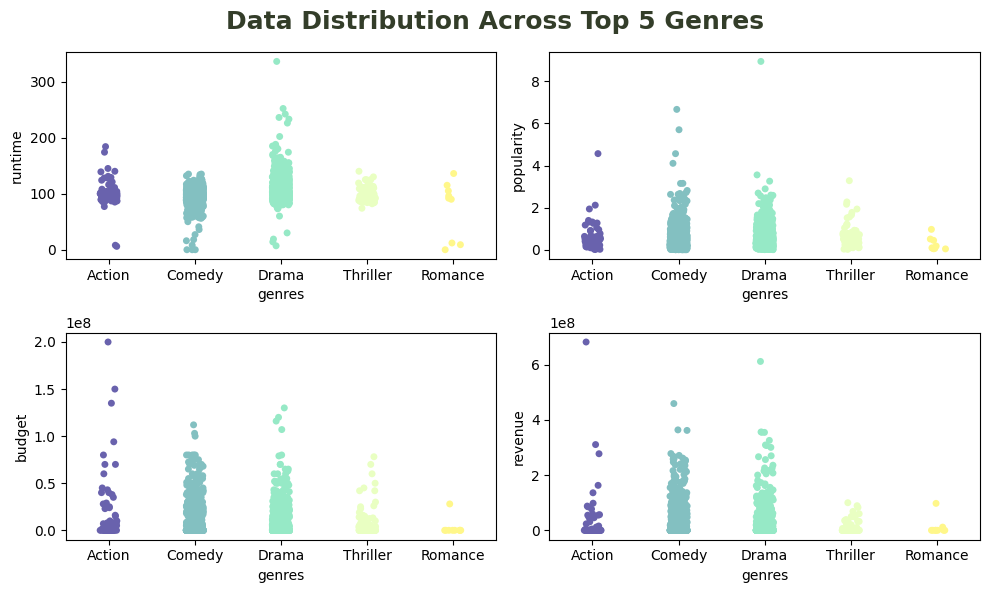

In [15]:
# Data Distribution Across Top 5 Genres
df_plot = pd.DataFrame(Counter(genre_list).most_common(5), columns=['genre', 'total'])
df_plot = df[df['genres'].isin(df_plot['genre'].to_numpy())]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

plt.suptitle('Data Distribution Across Top 5 Genres', fontsize=18, weight=600, color='#333d29')
for i, y in enumerate(['runtime', 'popularity', 'budget', 'revenue']):
    sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#6962AD', '#83C0C1', '#96E9C6', '#E9FFC2', '#FFF78A'])

plt.tight_layout()

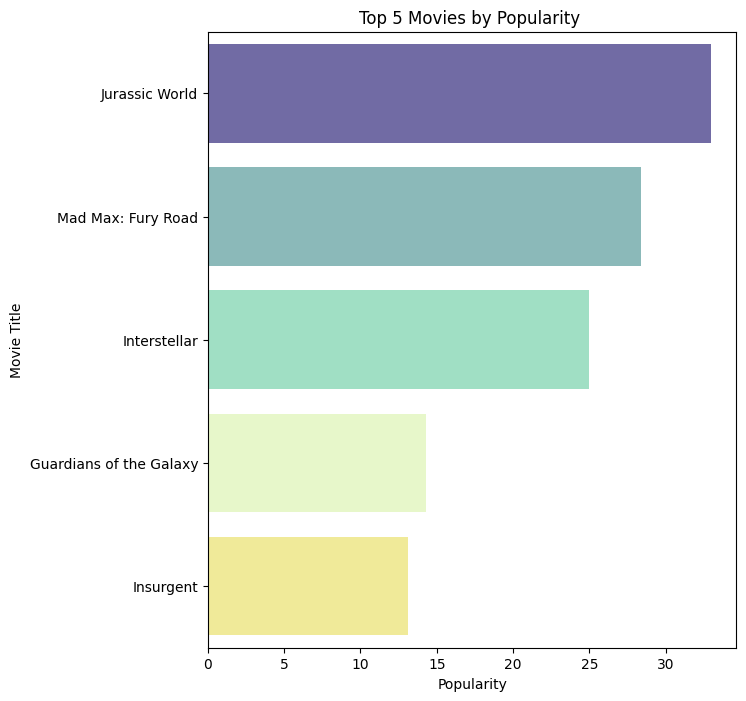

In [16]:

def top_movies(top_movies, figsize=(15, 8)):
    plt.figure(figsize=figsize)

    # Bar plot
    plt.subplot(1, 2, 1)
    sns.barplot(x='popularity', y='original_title', data=top_movies, palette=['#6962AD', '#83C0C1', '#96E9C6', '#E9FFC2', '#FFF78A'])
    plt.title('Top 5 Movies by Popularity ')
    plt.xlabel('Popularity')
    plt.ylabel('Movie Title')

top_5_popular_movies = df.nlargest(5, 'popularity')
top_movies(top_5_popular_movies)


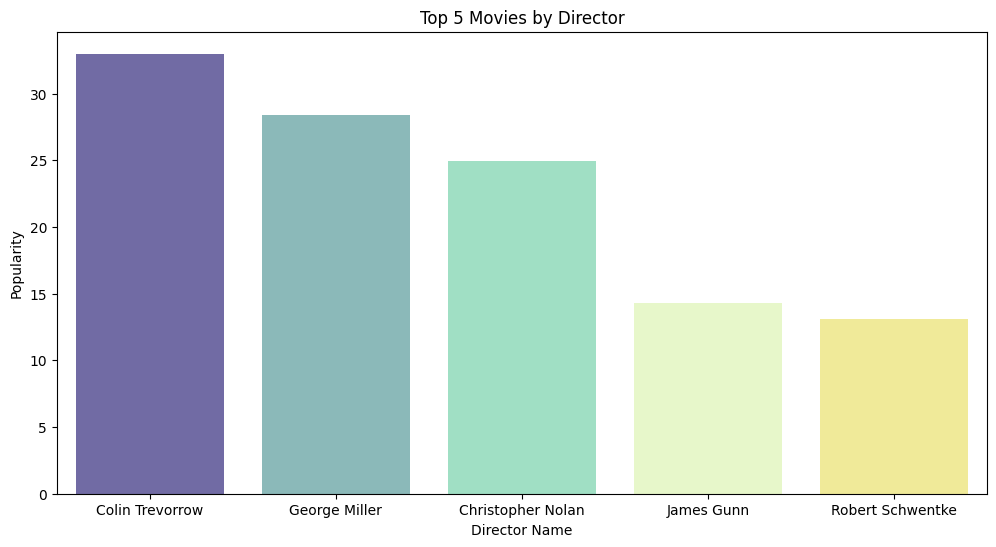

In [17]:
top_5_popular_director = df.sort_values(by='popularity', ascending=False).head(5)

plt.figure(figsize=(12, 6))
sns.barplot(x='director', y='popularity', data=top_5_popular_director, palette=['#6962AD', '#83C0C1', '#96E9C6', '#E9FFC2', '#FFF78A'])
plt.title('Top 5 Movies by Director')
plt.xlabel('Director Name')
plt.ylabel('Popularity')
plt.show()


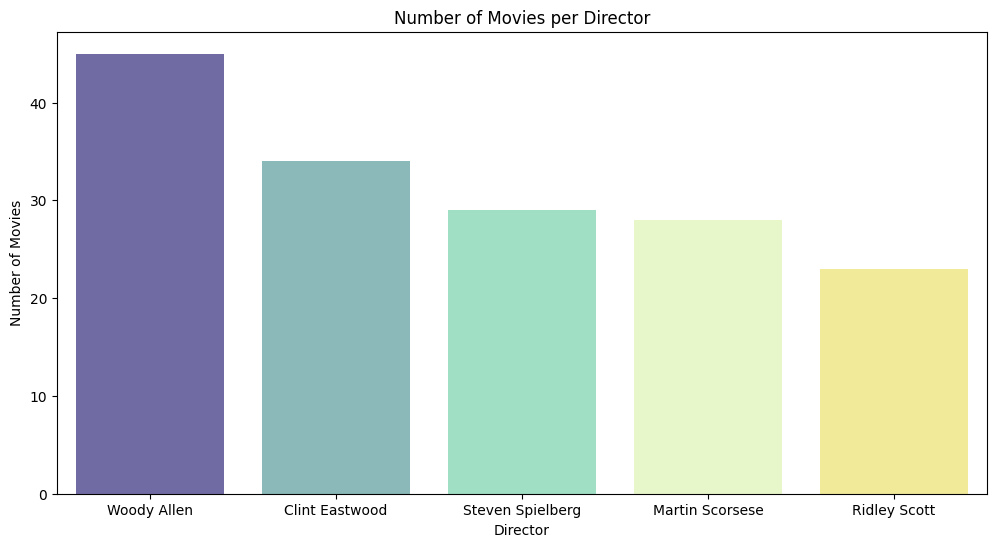

In [18]:
director_counts = df['director'].value_counts().head(5)

most_common_director = director_counts.idxmax()

plt.figure(figsize=(12, 6))
sns.barplot(x=director_counts.index, y=director_counts.values, palette=['#6962AD', '#83C0C1', '#96E9C6', '#E9FFC2', '#FFF78A'])
plt.title('Number of Movies per Director')
plt.xlabel('Director')
plt.ylabel('Number of Movies')
plt.show()


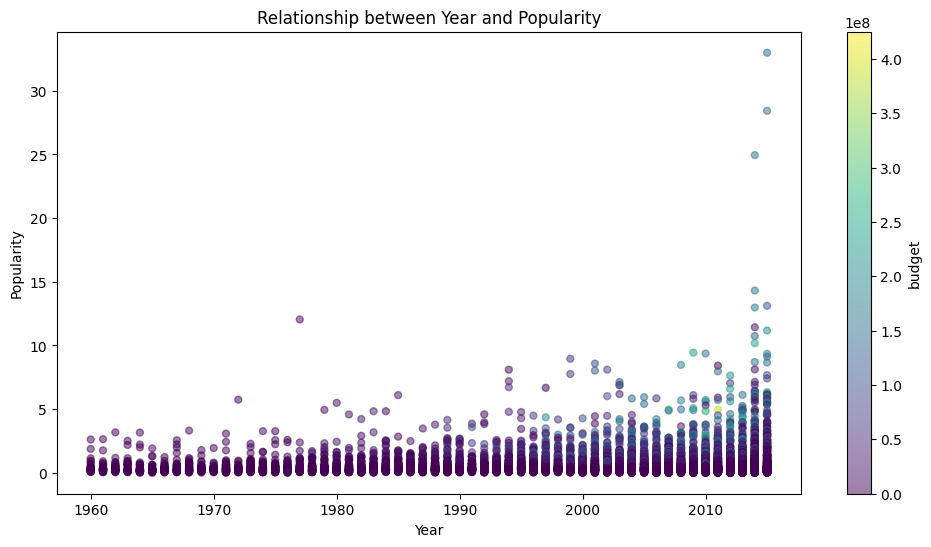

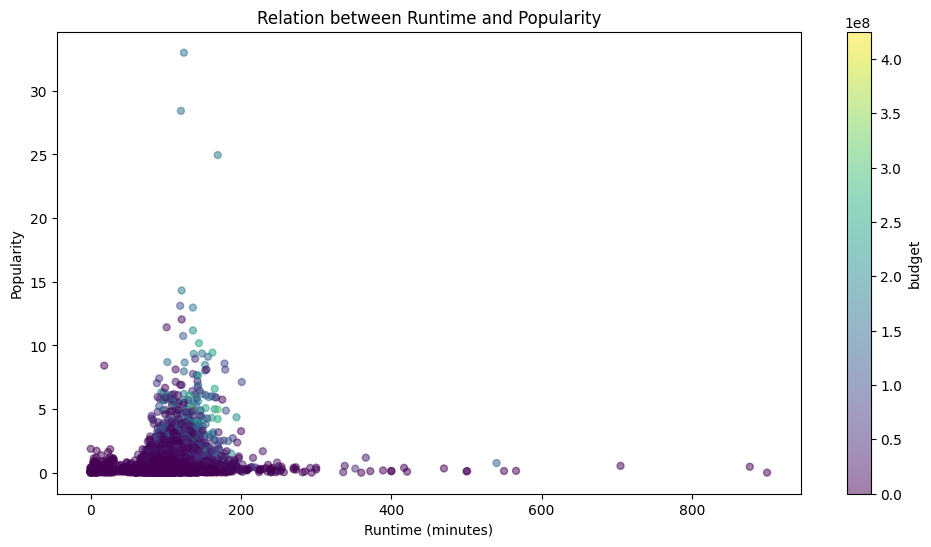

In [19]:
def scatter_plot(x, y, data, title, xlabel, ylabel, color_column=None):
    plt.figure(figsize=(12, 6))

    scatter_plot = plt.scatter(x=data[x], y=data[y], alpha=0.5, c=data[color_column], cmap='viridis', s=25)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if color_column:
        plt.colorbar(scatter_plot, label=color_column)

    plt.show()


scatter_plot('release_year', 'popularity', df, 'Relationship between Year and Popularity', 'Year', 'Popularity', color_column='budget')
scatter_plot('runtime', 'popularity', df, 'Relation between Runtime and Popularity', 'Runtime (minutes)', 'Popularity', color_column='budget')

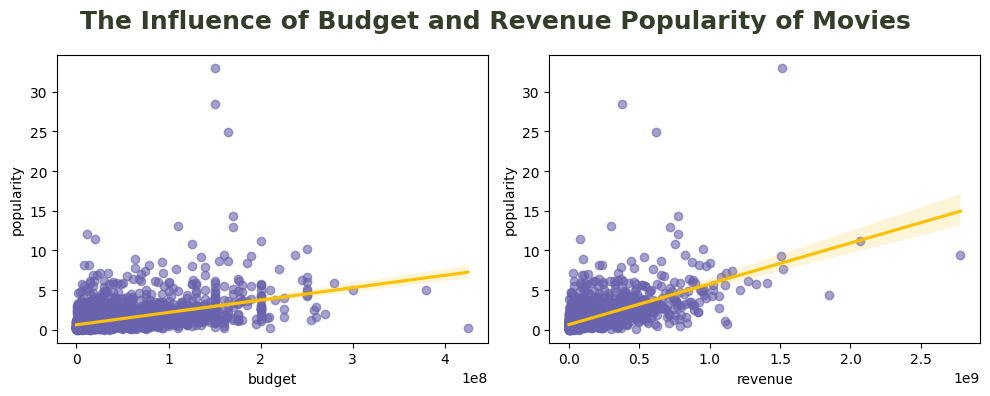

In [20]:
# Create regression plots showing the relationship between 'budget' and 'revenue' columns and 'popularity'
df_plot = df[(df['budget'] != 0) & (df['revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('The Influence of Budget and Revenue Popularity of Movies', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['budget', 'revenue']):
    sns.regplot(data=df_plot, x=col, y='popularity',
                scatter_kws={"color": "#6962AD", "alpha": 0.6}, line_kws={"color": "#fdc100"}, ax=axes[i])

plt.tight_layout()

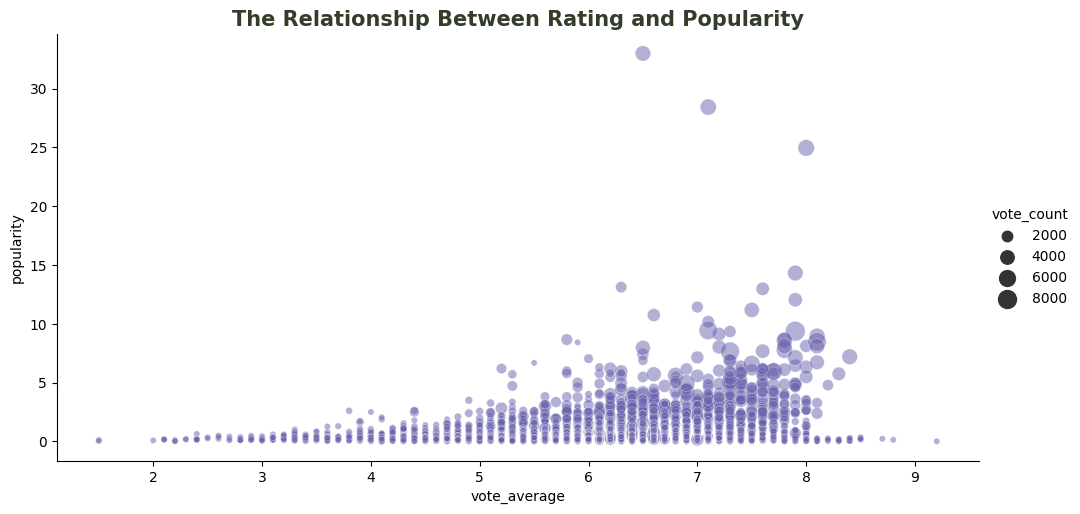

In [21]:
# scatter plot showing the relationship between 'vote_average' and 'popularity'
# The size of each point is taken from the 'vote_count' column

sns.relplot(data=df, x='vote_average', y='popularity', size='vote_count',
            sizes=(20, 200), alpha=.5, aspect=2, color='#6962AD')
plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29');

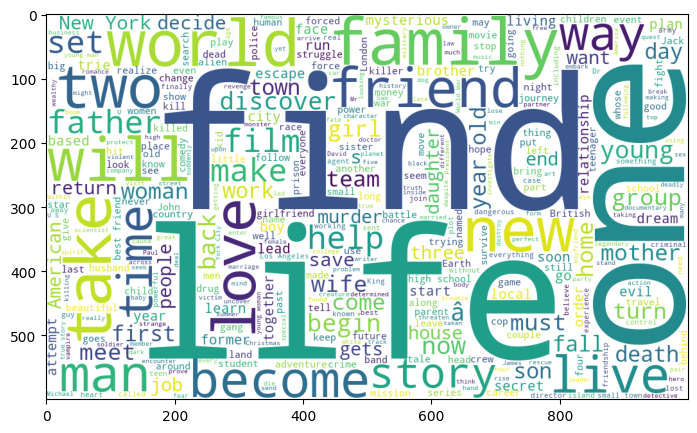

In [22]:
plt.figure(figsize=(12,5))
wordcloud = WordCloud(max_words=1000, min_font_size=10,
                height=600 ,width=1000, background_color="white").generate(' '.join(df['overview']))

plt.imshow(wordcloud)

 ## Building a Recommender System

### Content Based Filtering (İçerik Temelli Filtreleme)

In [23]:
# Required columns
df2 = df[['id','original_title', 'cast', 'director', 'overview', 'genres']]
df2.head(3)

,id,original_title,cast,director,overview,genres
0,135397,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,Twenty-two years after the events of Jurassic ...,Action|Adventure|Science Fiction|Thriller
1,76341,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,An apocalyptic story set in the furthest reach...,Action|Adventure|Science Fiction|Thriller
2,262500,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,Beatrice Prior must confront her inner demons ...,Adventure|Science Fiction|Thriller


In [24]:
df2['cast'] = df2['cast'].apply(lambda x: x.replace("|", ","))
df2['genres'] = df2['genres'].apply(lambda x: x.replace("|", ","))

In [25]:
# Lowercase
def lowercase_conversion(data, columns):
    for column in columns:
        data[column] = data[column].apply(lambda x: " ".join(x.lower() for x in x.split()))
    return data

df2 = lowercase_conversion(df2, ['cast', 'director', 'overview', 'genres'])

In [26]:
# Remove the gaps
def remove_spaces(data, columns):
    for column in columns:
        data[column] = data[column].apply(lambda x: " ".join(x.split()))
    return data
df2 = remove_spaces(df2, ['cast', 'director', 'overview'])

In [27]:
# Remove numbers
def remove_numbers(data, columns):
    for column in columns:
        data[column] = data[column].apply(lambda x: re.sub(r'\d+', '', x))
    return data

df2 = remove_numbers(df2, ['cast', 'director', 'overview'])

In [28]:
# Remove stopwords
sw = set(stopwords.words("english"))
print(sw)
df2['overview'] = df2['overview'].apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))

{'with', 'can', 'again', 'up', "mightn't", 'who', "needn't", 'any', 'my', "couldn't", 'don', 'they', 'these', "shan't", "wasn't", 'most', 'because', 'd', 'if', 'by', 'a', 'hers', 'now', 'about', 'were', "won't", 'should', 'won', 'me', 'theirs', 'his', 'this', 'for', 'as', 'didn', 'doesn', 'wouldn', 'him', "isn't", 'does', "you're", 'below', 'be', 'on', 'between', 'while', 'own', "doesn't", 'no', 'those', 'was', 'she', 'how', 'shan', 'until', 'and', "didn't", "mustn't", 'both', 'other', 'yourself', 'yours', 'themselves', 'isn', 'through', 'being', "you'd", 'before', "you'll", 'yourselves', 'ain', 'further', 'our', "that'll", 'down', 'when', 'than', "aren't", "don't", 'where', 'itself', 'aren', "should've", 'doing', 'shouldn', 'so', 'he', 'all', 'only', 'is', 'which', "haven't", 'myself', 'you', 'that', 'have', 'few', 'o', 'there', 'them', 'having', 'himself', 'the', 'needn', 'nor', 'its', 'her', 'couldn', 'such', 'at', 's', 'will', "it's", 'each', 'what', 'ours', 'wasn', 'had', 'too', '

In [29]:
df2.head(3)

,id,original_title,cast,director,overview,genres
0,135397,Jurassic World,"chris pratt,bryce dallas howard,irrfan khan,vi...",colin trevorrow,twentytwo years after the events of jurassic p...,"action,adventure,science fiction,thriller"
1,76341,Mad Max: Fury Road,"tom hardy,charlize theron,hugh keays-byrne,nic...",george miller,an apocalyptic story set in the furthest reach...,"action,adventure,science fiction,thriller"
2,262500,Insurgent,"shailene woodley,theo james,kate winslet,ansel...",robert schwentke,beatrice prior must confront her inner demons ...,"adventure,science fiction,thriller"


In [30]:
df2["overview_cleaned"] = df2.overview.str.split(" ")
df2.overview_cleaned = df2.overview_cleaned.apply(lambda x: [i for i in x if i not in sw])

In [31]:
df2[['overview','overview_cleaned']]

,overview,overview_cleaned
0,twentytwo years after the events of jurassic p...,"[twentytwo, years, events, jurassic, park, isl..."
1,an apocalyptic story set in the furthest reach...,"[apocalyptic, story, set, furthest, reaches, p..."
2,beatrice prior must confront her inner demons ...,"[beatrice, prior, must, confront, inner, demon..."
3,thirty years after defeating the galactic empi...,"[thirty, years, defeating, galactic, empire, h..."
4,deckard shaw seeks revenge against dominic tor...,"[deckard, shaw, seeks, revenge, dominic, toret..."
...,...,...
10725,the endless summer by bruce brown is one of th...,"[endless, summer, bruce, brown, one, first, in..."
10726,grand prix driver pete aron is fired by his te...,"[grand, prix, driver, pete, aron, fired, team,..."
10727,an insurance agent who moonlights as a carthie...,"[insurance, agent, moonlights, carthief, steal..."
10728,in comic woody allens film debut he took the j...,"[comic, woody, allens, film, debut, took, japa..."


In [32]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Determining the word type using the POS tagger"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    """Return the given text by lemmatizing it"""
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text
df2['overview_cleaned'] = df2['overview_cleaned'].apply(lambda x: lemmatize_text(' '.join(x)))

In [33]:
df2.head(3)

,id,original_title,cast,director,overview,genres,overview_cleaned
0,135397,Jurassic World,"chris pratt,bryce dallas howard,irrfan khan,vi...",colin trevorrow,twentytwo years after the events of jurassic p...,"action,adventure,science fiction,thriller",twentytwo year event jurassic park isla nublar...
1,76341,Mad Max: Fury Road,"tom hardy,charlize theron,hugh keays-byrne,nic...",george miller,an apocalyptic story set in the furthest reach...,"action,adventure,science fiction,thriller",apocalyptic story set furthest reach planet st...
2,262500,Insurgent,"shailene woodley,theo james,kate winslet,ansel...",robert schwentke,beatrice prior must confront her inner demons ...,"adventure,science fiction,thriller",beatrice prior must confront inner demon conti...


In [34]:
# Create similarity matrices from text columns using TfidfVectorizer
tfidf = TfidfVectorizer(max_features=10000)

# Create a similarity matrix from the 'cast' column
tfidf_cast = tfidf.fit_transform(df2['cast']).toarray()
sim_cast = cosine_similarity(tfidf_cast)

# Create a similarity matrix from the 'director' column
tfidf_director = tfidf.fit_transform(df2['director']).toarray()
sim_director = cosine_similarity(tfidf_director)

# Create a similarity matrix from the 'genres' column
tfidf_genres = tfidf.fit_transform(df2['genres']).toarray()
sim_genres = cosine_similarity(tfidf_genres)

# Create a similarity matrix from the 'overview_cleaned' column
tfidf_overview_cleaned = tfidf.fit_transform(df2['overview_cleaned']).toarray()
sim_overview_cleaned = cosine_similarity(tfidf_overview_cleaned)

In [35]:
# Create a weighted similarity matrix between different features
similarity = (0.35 * sim_genres)  + (0.15 * sim_cast) + (0.15 * sim_director) + (0.35 * sim_overview_cleaned)

In [36]:
# A function that finds recommended movies based on a given movie name and the total similarity matrix
def recommend(movie_name, similarity):
    movie_index = df2[df2['original_title'] == movie_name].index[0]
    similarity_array = similarity[movie_index]
    similar_movies = sorted(list(enumerate(similarity_array)), reverse=True, key=lambda x: x[1])[1:11]
    for i in similar_movies:
        print(df2.iloc[i[0]]['original_title'])

In [37]:
# Making suggestions for the movie "Jurassic World"
recommend("Jurassic World", similarity)

The Lost World: Jurassic Park
Futureworld
Jurassic Park
Terminator Genisys
The Last Starfighter
Jurassic Park III
Guardians of the Galaxy
I Am Number Four
The Chronicles of Riddick
Jurassic City


In [38]:
tfidf_genres[1]

array([0.39308192, 0.46885441, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.49739618,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.49739618, 0.36174054, 0.        ,
       0.        , 0.        ])

In [39]:
def recommend_movie(movie_name, similarity_matrix):
    movie_index = df2[df2['original_title'] == movie_name].index[0]
    similarity_array = similarity_matrix[movie_index]
    similar_movies = sorted(list(enumerate(similarity_array)), reverse=True, key=lambda x: x[1])[1:11]
    for i in similar_movies:
        print(df2.iloc[i[0]]['original_title'])

In [40]:
recommend_movie("Jurassic World", sim_genres)

Mad Max: Fury Road
Terminator Genisys
Vice
Halo: Nightfall
G.I. Joe: The Rise of Cobra
Universal Soldier: Regeneration
Street Fighter: The Legend of Chun-Li
X-Men Origins: Wolverine
Hardwired
Predators


### Simple Recommenders (Basit Tavsiye Sistemleri)

 Weighted Rating (WR) = ((v + m) / v) * R + (m / (v + m)) * C

- v : film veya öğeye verilen toplam oy sayısını,

- m : belirlenen bir oy eşiğini (örneğin, en az kaç oy alması gerektiği),

- R : ortalama oy değerini (veya başka bir oy ölçüsünü),

- C : bütün filmlerin ortalama oy değerini temsil eder.



In [41]:
# Required columns
df3 = df[['id','original_title', 'vote_count', 'vote_average', 'popularity']]
df3.head(3)

,id,original_title,vote_count,vote_average,popularity
0,135397,Jurassic World,5562,6.5,32.985763
1,76341,Mad Max: Fury Road,6185,7.1,28.419936
2,262500,Insurgent,2480,6.3,13.112507


In [42]:
C = df3['vote_average'].mean()
print(C)

5.964898872215491


In [43]:
m = df3['vote_count'].quantile(0.90)
print(m)

519.0


In [44]:
df3 = df3.loc[df3['vote_count'] >= m]
df3.shape

(1074, 5)

In [45]:
# A function that calculates the weighted rating
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
   
    return (v/(v+m) * R) + (m/(m+v) * C)

In [46]:
df3['score'] = df3.apply(weighted_rating, axis=1)

In [47]:
df3 = df3.sort_values('score', ascending=False)

# Choosing the 10 movies with the highest 'score'
df3[['original_title', 'vote_count', 'vote_average', 'score']].head(10)

,original_title,vote_count,vote_average,score
4102,The Shawshank Redemption,5754,8.4,8.198531
7160,The Godfather,3970,8.3,8.030025
2821,The Dark Knight,8432,8.1,7.976202
2356,Fight Club,5923,8.1,7.927985
4101,Pulp Fiction,5343,8.1,7.910966
4103,Forrest Gump,4856,8.1,7.893839
617,Interstellar,6498,8.0,7.849477
1880,Inception,9767,7.9,7.802361
638,Whiplash,2372,8.2,7.798749
7200,The Empire Strikes Back,3954,8.0,7.763868
